In [3]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2



In [9]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear3 = nn.Linear(128, self.action_size)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        output = self.linear3(output)
        distribution = F.softmax(output, dim=-1)
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, state):
        output = F.relu((self.linear1(state)))
        # output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment

    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''

    #convert state to float tensor, add 1 dimension, allocate tensor on device
    # state = torch.from_numpy(state).float().unsqueeze(0)

    #use network to predict action probabilities
    # print(network(state))
    action_probs = network(state)
    state = state.detach()

    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action, m.log_prob(action)

In [16]:
env = gym.make("MountainCar-v0")


28
19
12
18
12
17
29
19
34
12
20
19
12
29
25
55
24
13
18
15
14
13
23
21
14
14
11
14
22
36
32
12
12
17
17
19
18
11
12
27
10
13
21
10
11
18
19
26
24
23
19
17
10
24
40
51
14
35
10
14
54
33
15
13
14
20
25
10
15
18
13
52
22
10
16
12
18
20
22
25
22
21
33
18
21
11
15
12
28
43
31
20
17
12
13
18
38
14
20
23
27
21
8
16
27
20
57
11
44
20
46
8
22
24
25
37
10
37
28
20
24
16
15
26
29
36
23
11
19
24
13
11
26
16
24
18
19
14
21
17
17
14
19
15
16
9
29
20
12
15
9
12
30
13
22
26
13
16
17
14
13
12
14
15
30
17
16
64
15
20
13
21
15
16
12
13
47
16
25
21
14
22
23
11
35
13
21
15
31
25
31
28
15
52
31
13
15
15
12
15
16
23
18
10
21
13
11
21
22
14
12
24
14
15
12
28
38
20
19
15
26
17
17
11
9
62
17
22
32
18
26
20
33
11
19
35
29
14
11
23
14
22
15
18
31
18
11
10
17
12
11
13
11
23
46
10
18
9
13
10
14
37
15
34
14
9
10
24
15
12
11
22
23
14
18
10
16
11
31
11
19
34
9
21
14
26
14
16
11
19
34
30
51
25
10
29
11
21
13
15
27
13
14
19
39
12
13
35
12
21
13
25
14
13
28
16
44
31
15
25
11
54
34
30
46
22
18
20
12
17
12
21
20
26
12
22


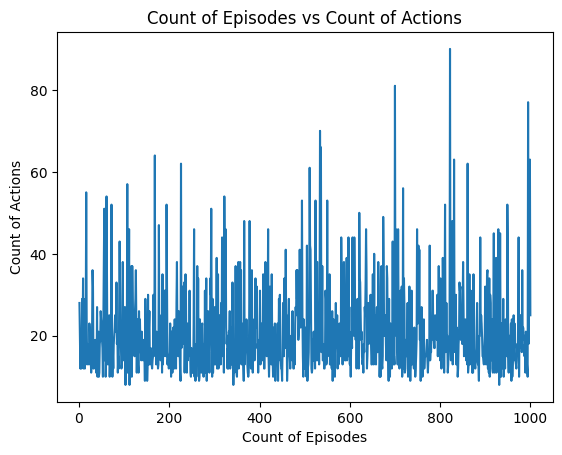

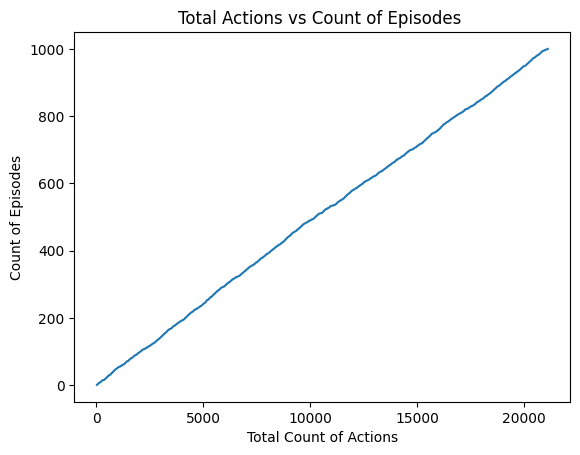

In [22]:
gamma = 0.99
num_episodes = 1000
num_steps = 1000
# env = gym.make("MountainCar-v0")
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

actor = Actor(state_size, action_size)
critic = Critic(state_size, action_size)

count_episode = range(1,num_episodes+1)
count_actions = []
total_count_actions = []
total_a = 0
for episode in range(num_episodes):
    actor_optim = optim.Adam(actor.parameters(),lr=0.05)
    critic_optim = optim.Adam(critic.parameters(), lr=0.05)
    state = env.reset()
    isTerminal = False
    score = 0
    
    count_a = 0
    
    # for i in range(num_steps): 
    while not isTerminal:
        count_a += 1
        state = torch.FloatTensor(state)
        with torch.no_grad():
            action, log_prob = select_action(network=actor, state=state)
            # action = torch.argmax(actor(state))
            # log_prob = torch.max(actor(state))
        state_prime, reward, isTerminal, info = env.step(action.item())
        state_prime = torch.FloatTensor(state_prime)
        # if state_prime[0] >= 0.5:
        #     print(f'Num episodes {episode}, num actions {i} {isTerminal}')
        #     v_next = torch.tensor([0]).float().unsqueeze(0)
        # if isTerminal:
        #     print(f'Num episodes {episode}, num actions {i} {isTerminal}')
        v_curr = critic(state)
        v_next = critic(state_prime)
            

        td_target = reward + gamma * v_next
        td_error = reward + ((gamma*v_next)-v_curr)
        
        # print(v_curr)
        # print(log_prob)
        # Policy
        actor_loss = reward + (gamma*v_next-v_curr)
        actor_loss *= -log_prob
        actor_optim.zero_grad()
        actor_loss.backward(retain_graph=True)
        actor_optim.step()

        # Value
        critic_loss = F.mse_loss(reward + gamma * v_next,v_curr)
        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()
        state = state_prime

        # print(f'Actor loss is {actor_loss} and critic loss is {critic_loss}')
        # if state_prime[0] >= 0.5:
        #     break
        # print(state)
    print(count_a)
    count_actions.append(count_a)
    total_a += count_a
    total_count_actions.append(total_a)
      
torch.save(actor, 'actor.pkl')
torch.save(critic, 'critic.pkl')
env.close()        

plt.figure()
plt.title('Count of Episodes vs Count of Actions')
plt.xlabel('Count of Episodes')
plt.ylabel('Count of Actions')
plt.plot(count_episode, count_actions)
plt.savefig('count_actions_ac.jpg')
plt.show()

plt.figure()
plt.title('Total Actions vs Count of Episodes ')
plt.ylabel('Count of Episodes')
plt.xlabel('Total Count of Actions')
plt.plot(total_count_actions, count_episode)
plt.savefig('total_actions_ac.jpg')
plt.show()

In [16]:
state

tensor([-0.3171,  0.0036])

In [24]:
import gym
# env = gym.make('MountainCar-v0')
env.reset()

while not isTerminal:
    action = torch.argmax(actor(state))
    state_prime, reward, isTerminal, info = env.step(action.item())
    state_prime = torch.FloatTensor(state_prime)
    state = state_prime
    # env.step(env.action_space.sample())
    env.render()